In [1]:
import pandas as pd
import numpy as np

pathDict = {
    "femaleV1":{"rsp":"liwc_female_responses", "vals":"liwc_female_orig_mod_vals", "mod_feat":"liwc_femal_mod", "orig_feat":"liwc_femal_orig"},
    "femaleV2":{"rsp":"liwc_female_v2_responses", "vals":"liwc_female_orig_mod_vals", "mod_feat":"liwc_femal_mod", "orig_feat":"liwc_femal_orig"},
    "my_mine":{"rsp":"my_mine_responses_1", "vals":"my_mine_orig_mod_vals", "mod_feat":"my_mine_mod", "orig_feat":"my_mine_orig"}
}
experiment = "my_mine"
responses = pd.read_csv("../datasets/"+pathDict[experiment]["rsp"]+".csv") #Options: "liwc_female_responses.csv", "liwc_female_v2_responses.csv"
liwc_vals = pd.read_csv("../datasets/"+pathDict[experiment]["vals"]+".csv") #Options: "liwc_female_orig_mod_vals.csv", "my_mine_orig_mod_vals.csv"
print(liwc_vals.columns)
print(responses.columns)

Index(['post_id', 'my_mine_orig', 'AHR original predict',
       'AHR original actual', 'AHR modified predict', 'my_mine_mod'],
      dtype='object')
Index(['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)',
       'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel',
       'UserLanguage', 'consent', 'graphic', 'heartatk', 'scenario_1_action',
       'scenario_1_person', 's1t_First Click', 's1t_Last Click',
       's1t_Page Submit', 's1t_Click Count', 'scenario_2_action',
       'scenario_2_person', 's2t_First Click', 's2t_Last Click',
       's2t_Page Submit', 's2t_Click Count', 'scenario_3_action',
       'scenario_3_person', 's3t_First Click', 's3t_Last Click',
       's3t_Page Submit', 's3t_Click Count', 'scenario_4_action',
       'scenario_4_person', 's4t_First Click', 's4t_Last Click',
       's4t_Page Submit', 's4t_Click Count', 'scenario_5_action',
       'scenario_5_person', 's5t_First Click', 's5t_Last Click',
       's5t_Page Submit', 's5t_Cl

In [61]:
print(responses.shape)

(540, 80)


In [62]:
print(responses['AC'].value_counts())
print(responses['q_3_is_modified'].isna().sum())


1                                                                 478
2                                                                   5
5                                                                   4
3                                                                   2
In this task, you read five passages that all dealt with what?      1
{"ImportId":"QID73"}                                                1
4                                                                   1
Name: AC, dtype: int64
254


In [63]:
df = responses.loc[(responses["heartatk"] =="4")& (responses["consent"] =="1")]

df_fil = df.dropna(subset=["scenario_1_action", "scenario_2_action", "scenario_3_action", "scenario_4_action", "scenario_5_action"])
df_fil = df_fil.dropna(subset=["scenario_1_person", "scenario_2_person", "scenario_3_person", "scenario_4_person", "scenario_5_person"])
df_fil = df_fil.dropna(subset=["q_1_id", "q_2_id", "q_3_id", "q_4_id", "q_5_id"])
print(df.shape)
colMax = {1: {"action":df_fil["scenario_1_action"].astype("int").max(), "person":df_fil["scenario_1_person"].astype("int").max()}, 2: {"action":df_fil["scenario_2_action"].astype("int").max(), "person":df_fil["scenario_2_person"].astype("int").max()}, 3: {"action":df_fil["scenario_3_action"].astype("int").max(), "person":df_fil["scenario_3_person"].astype("int").max()}, 4: {"action":df_fil["scenario_4_action"].astype("int").max(), "person":df_fil["scenario_4_person"].astype("int").max()}, 5: {"action":df_fil["scenario_5_action"].astype("int").max(), "person":df_fil["scenario_5_person"].astype("int").max()}, }
colMin = {1: {"action":df_fil["scenario_1_action"].astype("int").min(), "person":df_fil["scenario_1_person"].astype("int").min()}, 2: {"action":df_fil["scenario_2_action"].astype("int").min(), "person":df_fil["scenario_2_person"].astype("int").min()}, 3: {"action":df_fil["scenario_3_action"].astype("int").min(), "person":df_fil["scenario_3_person"].astype("int").min()}, 4: {"action":df_fil["scenario_4_action"].astype("int").min(), "person":df_fil["scenario_4_person"].astype("int").min()}, 5: {"action":df_fil["scenario_5_action"].astype("int").min(), "person":df_fil["scenario_5_person"].astype("int").min()}, }
print(colMax)
print(colMin)

(532, 80)
{1: {'action': 46, 'person': 44}, 2: {'action': 39, 'person': 37}, 3: {'action': 39, 'person': 37}, 4: {'action': 39, 'person': 37}, 5: {'action': 39, 'person': 37}}
{1: {'action': 40, 'person': 38}, 2: {'action': 33, 'person': 31}, 3: {'action': 33, 'person': 31}, 4: {'action': 33, 'person': 31}, 5: {'action': 33, 'person': 31}}


In [64]:
print(df['scenario_1_action'].value_counts())
print(df.shape)

40    175
41     84
42     67
44     52
43     49
45     37
46     36
Name: scenario_1_action, dtype: int64
(532, 80)


In [65]:
import math
csv_col_modified = pathDict[experiment]["mod_feat"] 
csv_col_orig = pathDict[experiment]["orig_feat"]    
def recodeValues(columnIdx, isAction, value):
    if str(value).strip().lower()=="nan":
        return None
    value = int(value)
    return value - colMin[columnIdx]["action" if isAction else "person"] +1
    
def getLiwcVals(type, id):
    col = csv_col_orig if type == "orig" else csv_col_modified
    print(id)
    to_ret =liwc_vals.loc[liwc_vals["post_id"]==id][col].item()
    return float(to_ret)
    
new_format =[]
# New format is: id, is_modified, answer_action,answer_person
badEntryCounter=0
for index, row in df.iterrows():
    dmy = str(row["gender"]).strip().lower()
    gender = None
    if dmy == "4":
        gender =1
    elif dmy=="5":
        gender = -1
    elif dmy=="6":
        gender = 2
    elif dmy=="7":
        gender=3
    else:
        badEntryCounter+=1

    for i in range(1,6):
        r_id = row[f"q_{i}_id"]
       
        #if  math.isnan(r_id):
        #    badEntryCounter+=1
        #    #not sure if bad entry counter is correct or should be diveded by 4
        #    continue
       
        r_isMod = 1 if row[f"q_{i}_is_modified"] == "true" else -1
        r_action =  recodeValues(i, True, row[f"scenario_{i}_action"])
        r_person = recodeValues(i, False, row[f"scenario_{i}_person"])
        r_age = None if str(row["age"]).strip().lower() == "nan" else int(row["age"])
        r_gender = gender
        r_responseId = row["ResponseId"]
        r_ac = row["AC"]

        if "IMTA for getting a cat" in r_id:
            r_id = "k5kh4d"
        r_liwcOrig = getLiwcVals("orig", r_id)
        r_liwcMod = getLiwcVals("modified", r_id)
        print(r_id)
        cond_low = ["k5n8gp","ayuhfj","d7rqv7","da5lf4","d8tktt","di121p","e6gioh","kbfqn0","d7bwco","lflkbi","ghb1qd","dq7o60","c16a49","azhjxy","b6ex3u","bt96e5","jmyghg","acx62a","cwd2sm","d11pwp"]
        cond_high=["d2z9tl","j0rubv","dhswh1","hptojb","eq475l","Ds0fwd","ikxa0t","jpgxl6","bt8iou","ec7ciw","ehyyhk","ck5jvn","m46pif","lol9kc","bs5p6l","dn6075","jncy5t","hql2q4","cjudzm","n2wjkt"]
        r_is_cond_high = 1 if r_id in cond_high else -1
        r_i = [r_id, r_isMod, r_action, r_person, r_age, r_gender, r_responseId, r_ac, r_liwcOrig, r_liwcMod, r_is_cond_high ]
        new_format.append(r_i)


print("NAN values:",badEntryCounter)
df_new_format = pd.DataFrame(np.array(new_format), columns=['scenarioId', 'isModified', 'scenarioAction', 'scenarioPerson', "age", "gender", "responseId", "acResponse", "originalFeatureValue", "modifiedFeatureValue", "isConditionalHigh"], )
df_new_format["isModified"] = df_new_format["isModified"].astype("Int64")
df_new_format["scenarioAction"] = df_new_format["scenarioAction"].astype("Int64")
df_new_format["scenarioPerson"] = df_new_format["scenarioPerson"].astype("Int64")
df_new_format["gender"] = df_new_format["gender"].astype("Int64")
df_new_format["age"] = df_new_format["age"].astype("Int64")
df_new_format["originalFeatureValue"] = df_new_format["originalFeatureValue"].astype("Float64")
df_new_format["modifiedFeatureValue"] = df_new_format["modifiedFeatureValue"].astype("Float64")
df_new_format["isConditionalHigh"] = df_new_format["isConditionalHigh"].astype("Int64")

print("TRANSFORMED OUTPUT STILL CONTAINS ATTENTION CHECK")

ay3kdp
ay3kdp
ay3kdp
bli4mz
bli4mz
bli4mz
blubn0
blubn0
blubn0
e554ox
e554ox
e554ox
efa2c0
efa2c0
efa2c0
g18tep
g18tep
g18tep
e554ox
e554ox
e554ox
aojzfj
aojzfj
aojzfj
ajdybt
ajdybt
ajdybt
ikxqk1
ikxqk1
ikxqk1
i0lgy2
i0lgy2
i0lgy2
l2zhzl
l2zhzl
l2zhzl
d21pgp
d21pgp
d21pgp
ca0xic
ca0xic
ca0xic
ajdybt
ajdybt
ajdybt
ikxqk1
ikxqk1
ikxqk1
e554ox
e554ox
e554ox
l2zhzl
l2zhzl
l2zhzl
aojzfj
aojzfj
aojzfj
i0lgy2
i0lgy2
i0lgy2
e554ox
e554ox
e554ox
ajdybt
ajdybt
ajdybt
d21pgp
d21pgp
d21pgp
k5kh4d
k5kh4d
k5kh4d
c9i8f6
c9i8f6
c9i8f6
c9i8f6
c9i8f6
c9i8f6
d21pgp
d21pgp
d21pgp
g18tep
g18tep
g18tep
blubn0
blubn0
blubn0
jpilct
jpilct
jpilct
efa2c0
efa2c0
efa2c0
dhrwm8
dhrwm8
dhrwm8
bli4mz
bli4mz
bli4mz
ay3kdp
ay3kdp
ay3kdp
e554ox
e554ox
e554ox
dhrwm8
dhrwm8
dhrwm8
ay3kdp
ay3kdp
ay3kdp
k5kh4d
k5kh4d
k5kh4d
ikxqk1
ikxqk1
ikxqk1
e554ox
e554ox
e554ox
ikxqk1
ikxqk1
ikxqk1
i0lgy2
i0lgy2
i0lgy2
jpilct
jpilct
jpilct
ca0xic
ca0xic
ca0xic
e554ox
e554ox
e554ox
l2zhzl
l2zhzl
l2zhzl
ay3kdp
ay3kdp
ay3kdp
e554ox
e554ox

In [66]:
print(df_new_format.shape)
print(df_new_format.dtypes)

(2660, 10)
scenarioId               object
isModified                Int64
scenarioAction            Int64
scenarioPerson            Int64
age                       Int64
gender                    Int64
responseId               object
acResponse               object
originalFeatureValue    Float64
modifiedFeatureValue    Float64
dtype: object


In [67]:
#print(df_new_format['scenarioPerson'].value_counts())
#print(df_new_format["originalFeatureValue"].head(10))
print(df_new_format.isna().sum())
print(df_new_format.isin(['nan']).sum(axis=0))

scenarioId                0
isModified                0
scenarioAction          190
scenarioPerson          190
age                     210
gender                  210
responseId                0
acResponse              210
originalFeatureValue      0
modifiedFeatureValue      0
dtype: int64
scenarioId              0
isModified              0
scenarioAction          0
scenarioPerson          0
age                     0
gender                  0
responseId              0
acResponse              0
originalFeatureValue    0
modifiedFeatureValue    0
dtype: int64


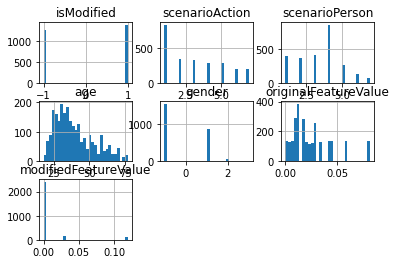

In [68]:
hist = df_new_format.hist(bins=30)

In [69]:
df_new_format.to_excel(pathDict[experiment]["rsp"]+"-transformed.xlsx", index=False)

In [70]:
df_new = df_new_format.dropna(axis='rows')
id_dict = {}
for index, row in df_new.iterrows():
    id = row["scenarioId"]
    jdgAction = row["scenarioAction"]
    jdgPerson = row["scenarioPerson"]
    
    isMod = row["isModified"]
    if id in id_dict:
        tmp = id_dict[id]
        tmp["action"+str(isMod)].append(jdgAction)
        tmp["person"+str(isMod)].append(jdgPerson)
        id_dict[id] = tmp
    else:
        tmp = {}
        if isMod > 0:
            tmp["action-1"] = []
            tmp["person-1"] = []
            tmp["action1"] = [jdgAction]
            tmp["person1"] = [jdgPerson]
        else: 
            tmp["action1"] = []
            tmp["person1"] = []
            tmp["action-1"] = [jdgAction]
            tmp["person-1"] = [jdgPerson]
        id_dict[id] = tmp


In [74]:
import statistics
data = []
for index, row in liwc_vals.iterrows():
    AHR_orig = row["AHR original actual"]
    my_mine_orig = row["my_mine_orig"]
    my_mine_modified = row["my_mine_mod"]
    id = row["post_id"]
    actionModified = statistics.mean(id_dict[id]["action1"])
    personModified = statistics.mean(id_dict[id]["person1"])
    actionOrig = statistics.mean(id_dict[id]["action-1"])
    personOrig = statistics.mean(id_dict[id]["person-1"])
    tmp_row =[id, AHR_orig, my_mine_orig, actionOrig, personOrig, my_mine_modified, actionModified, personModified]
    tmp_row_np = np.array(list(map(lambda x:str(x), tmp_row)))
    data.append(tmp_row_np)

np_data = np.array(data,dtype=object)
print(np_data.shape)

df_dunno = pd.DataFrame(np_data,
                   columns=['post_id', 'asshole_ratio_original', 'my_mine_original', "action_avg_original", "person_avg_original", "my_mine_modified","action_avg_modified", "person_avg_modified"])

df_dunno.to_excel("my_mine_check.xlsx",index=False)

(20, 8)
